In [1]:
import os 
import sys
import random
import math
import numpy as np
import cv2
import matplotlib.pyplot as plt
import json
import pydicom
from imgaug import augmenters as iaa
from tqdm import tqdm
import pandas as pd 
import glob

In [2]:
# Root directory of the project
ROOT_DIR = os.path.abspath('../../kag_rsna')

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, 'logs')
if not os.path.exists(MODEL_DIR):
    os.makedirs(MODEL_DIR)
os.chdir(MODEL_DIR)

### Install Mask_RCNN before continuing

### Notes
Problems :
upgrade setuptools first

 File "/Users/dumjax/Documents/venvs/venv_kag_rsna/lib/python3.7/site-packages/tensorflow/python/pywrap_tensorflow_internal.py", line 114
    def TFE_ContextOptionsSetAsync(arg1, async):
                                             ^
SyntaxError: invalid syntax

USE a virtualenv with PYTHON 3.6

In [3]:
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

/Users/dumjax/Documents/venvs/venv_kag_rsna36/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
Using TensorFlow backend.


In [4]:
train_dicom_dir = os.path.join(ROOT_DIR, 'data/stage_1_train_images')
test_dicom_dir = os.path.join(ROOT_DIR, 'data/stage_1_test_images')

In [5]:
def get_dicom_fps(dicom_dir):
    dicom_fps = glob.glob(dicom_dir+'/'+'*.dcm')
    return list(set(dicom_fps))

def parse_dataset(dicom_dir, anns): 
    image_fps = get_dicom_fps(dicom_dir)
    image_annotations = {fp: [] for fp in image_fps}
    for index, row in anns.iterrows(): 
        fp = os.path.join(dicom_dir, row['patientId']+'.dcm')
        image_annotations[fp].append(row)
    return image_fps, image_annotations

In [6]:
# The following parameters have been selected to reduce running time for demonstration purposes 
# These are not optimal 

class DetectorConfig(Config):
    """Configuration for training pneumonia detection on the RSNA pneumonia dataset.
    Overrides values in the base Config class.
    """
    
    # Give the configuration a recognizable name  
    NAME = 'pneumonia'
    
    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 2
    
    BACKBONE = 'resnet50'
    
    NUM_CLASSES = 2  # background + 1 pneumonia classes
    
    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 64
    IMAGE_MAX_DIM = 64
    
    RPN_ANCHOR_SCALES = (32, 64)
    
    TRAIN_ROIS_PER_IMAGE = 16
    
    MAX_GT_INSTANCES = 3
    
    DETECTION_MAX_INSTANCES = 3
    DETECTION_MIN_CONFIDENCE = 0.9
    DETECTION_NMS_THRESHOLD = 0.1
    
    RPN_TRAIN_ANCHORS_PER_IMAGE = 16
    STEPS_PER_EPOCH = 100 
    TOP_DOWN_PYRAMID_SIZE = 32
    STEPS_PER_EPOCH = 100
    
    
config = DetectorConfig()
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     2
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        3
DETECTION_MIN_CONFIDENCE       0.9
DETECTION_NMS_THRESHOLD        0.1
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 2
IMAGE_MAX_DIM                  64
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  64
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [64 64  3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES        

In [7]:
class DetectorDataset(utils.Dataset):
    """Dataset class for training pneumonia detection on the RSNA pneumonia dataset.
    """

    def __init__(self, image_fps, image_annotations, orig_height, orig_width):
        super().__init__(self)
        
        # Add classes
        self.add_class('pneumonia', 1, 'Lung Opacity')
   
        # add images 
        for i, fp in enumerate(image_fps):
            annotations = image_annotations[fp]
            self.add_image('pneumonia', image_id=i, path=fp, 
                           annotations=annotations, orig_height=orig_height, orig_width=orig_width)
            
    def image_reference(self, image_id):
        info = self.image_info[image_id]
        return info['path']

    def load_image(self, image_id):
        info = self.image_info[image_id]
        fp = info['path']
        ds = pydicom.read_file(fp)
        image = ds.pixel_array
        # If grayscale. Convert to RGB for consistency.
        if len(image.shape) != 3 or image.shape[2] != 3:
            image = np.stack((image,) * 3, -1)
        return image

    def load_mask(self, image_id):
        info = self.image_info[image_id]
        annotations = info['annotations']
        count = len(annotations)
        if count == 0:
            mask = np.zeros((info['orig_height'], info['orig_width'], 1), dtype=np.uint8)
            class_ids = np.zeros((1,), dtype=np.int32)
        else:
            mask = np.zeros((info['orig_height'], info['orig_width'], count), dtype=np.uint8)
            class_ids = np.zeros((count,), dtype=np.int32)
            for i, a in enumerate(annotations):
                if a['Target'] == 1:
                    x = int(a['x'])
                    y = int(a['y'])
                    w = int(a['width'])
                    h = int(a['height'])
                    mask_instance = mask[:, :, i].copy()
                    cv2.rectangle(mask_instance, (x, y), (x+w, y+h), 255, -1)
                    mask[:, :, i] = mask_instance
                    class_ids[i] = 1
        return mask.astype(np.bool), class_ids.astype(np.int32)

In [8]:
# training dataset
anns = pd.read_csv(os.path.join(ROOT_DIR, 'data/stage_1_train_labels.csv'))
anns.head(6)

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1
5,00436515-870c-4b36-a041-de91049b9ab4,562.0,152.0,256.0,453.0,1


In [9]:
image_fps, image_annotations = parse_dataset(train_dicom_dir, anns=anns)

In [10]:

ds = pydicom.read_file(image_fps[0]) # read dicom image from filepath 
image = ds.pixel_array # get image array

In [11]:
# show dicom fields 
ds

(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.276.0.7230010.3.1.4.8323329.6157.1517874324.43826
(0008, 0020) Study Date                          DA: '19010101'
(0008, 0030) Study Time                          TM: '000000.00'
(0008, 0050) Accession Number                    SH: ''
(0008, 0060) Modality                            CS: 'CR'
(0008, 0064) Conversion Type                     CS: 'WSD'
(0008, 0090) Referring Physician's Name          PN: ''
(0008, 103e) Series Description                  LO: 'view: AP'
(0010, 0010) Patient's Name                      PN: 'a96f7c2f-5ac2-4357-8cdf-4c364c6c8e6d'
(0010, 0020) Patient ID                          LO: 'a96f7c2f-5ac2-4357-8cdf-4c364c6c8e6d'
(0010, 0030) Patient's Birth Date                DA: ''
(0010, 0040) Patient's Sex                       CS: 'M'
(0010, 1010) Patient's 

In [12]:
# Original DICOM image size: 1024 x 1024
ORIG_SIZE = 1024

In [13]:
######################################################################
# Modify this line to use more or fewer images for training/validation. 
# To use all images, do: image_fps_list = list(image_fps)
image_fps_list = list(image_fps[:10]) 
#####################################################################

# split dataset into training vs. validation dataset 
# split ratio is set to 0.9 vs. 0.1 (train vs. validation, respectively)
sorted(image_fps_list)
random.seed(42)
random.shuffle(image_fps_list)

validation_split = 0.1
split_index = int((1 - validation_split) * len(image_fps_list))

image_fps_train = image_fps_list[:split_index]
image_fps_val = image_fps_list[split_index:]

print(len(image_fps_train), len(image_fps_val))

9 1


In [14]:
# prepare the training dataset
dataset_train = DetectorDataset(image_fps_train, image_annotations, ORIG_SIZE, ORIG_SIZE)
dataset_train.prepare()
# prepare the validation dataset
dataset_val = DetectorDataset(image_fps_val, image_annotations, ORIG_SIZE, ORIG_SIZE)
dataset_val.prepare()

In [15]:
# Show annotation(s) for a DICOM image 
test_fp = random.choice(image_fps_train)
image_annotations[test_fp]

[patientId    38c3c661-624a-4fdf-bd26-c7b33e20169a
 x                                             NaN
 y                                             NaN
 width                                         NaN
 height                                        NaN
 Target                                          0
 Name: 3507, dtype: object]

(1024, 1024, 3)
/Users/dumjax/OneDrive/01_DataScience/kag/kag_rsna/data/stage_1_train_images/54f4e2eb-e4f8-4c61-9be7-73cdb4492fbc.dcm
[0]


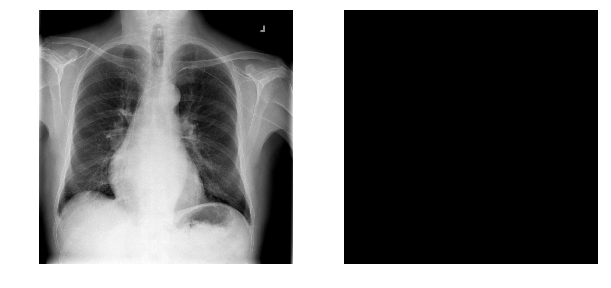

In [16]:
# Load and display random samples and their bounding boxes
# Suggestion: Run this a few times to see different examples. 

image_id = random.choice(dataset_train.image_ids)
image_fp = dataset_train.image_reference(image_id)
image = dataset_train.load_image(image_id)
mask, class_ids = dataset_train.load_mask(image_id)

print(image.shape)

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(image[:, :, 0], cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
masked = np.zeros(image.shape[:2])
for i in range(mask.shape[2]):
    masked += image[:, :, 0] * mask[:, :, i]
plt.imshow(masked, cmap='gray')
plt.axis('off')

print(image_fp)
print(class_ids)

In [17]:
model = modellib.MaskRCNN(mode='training', config=config, model_dir=MODEL_DIR)

In [18]:
# Image augmentation 
augmentation = iaa.SomeOf((0, 1), [
    iaa.Fliplr(0.5),
    iaa.Affine(
        scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
        translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
        rotate=(-25, 25),
        shear=(-8, 8)
    ),
    iaa.Multiply((0.9, 1.1))
])

### /!\ enlever multiprocessing si test sur laptop (Mask_RCNN/model.py line 2381 use_multiprocessing=False)

In [ ]:
NUM_EPOCHS = 1
# Train Mask-RCNN Model 
import warnings 
warnings.filterwarnings("ignore")
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=NUM_EPOCHS, 
            layers='all')
            #augmentation=augmentation)